In [1]:
from warnings import filterwarnings
#Data wrangling
import pandas as pd
import plotly.express as px
import numpy as np
import datetime

# Data visualization
import cufflinks as cf
import matplotlib.pyplot as plt

# Modeling
from keras import metrics
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 

# Environment setupt
cf.set_config_file(theme="white", offline=True)
filterwarnings("ignore")

2023-03-28 11:59:35.574890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 11:59:38.813227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 11:59:38.813272: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-28 11:59:45.659445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Load data

In [2]:
data= pd.read_csv("CrimenesTipo103Zona1.csv")

In [3]:
data["Date"]=data["date_rptd"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
date_index = pd.date_range(start=data["Date"].min(), end=data["Date"].max(), freq="D")
data = data.set_index("Date").reindex(date_index)
data.rename(columns={'0': "Crimes", "date_rptd": "AuxDate"}, inplace= True)

In [4]:
data.head()

,AuxDate,Crimes
2020-01-01,2020-01-01,5
2020-01-02,2020-01-02,7
2020-01-03,2020-01-03,25
2020-01-04,2020-01-04,10
2020-01-05,2020-01-05,11


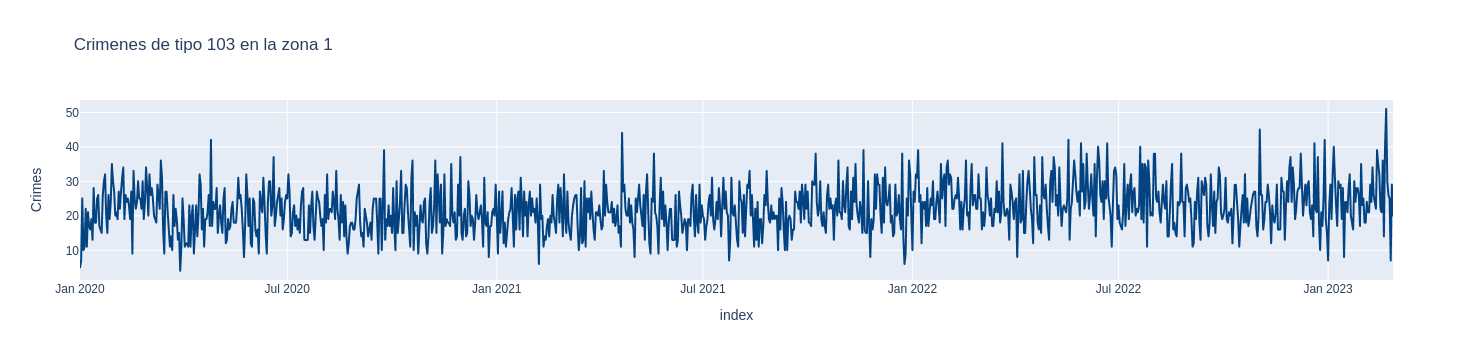

In [5]:
fig = px.line(data, x=data.index, y="Crimes",title=f"Crimenes de tipo 103 en la zona 1")
fig.update_traces(line_color='#044382')
fig.show()

## Preprossesing

In [6]:
df= data.copy()

### Manages Nan's 

In [7]:
df.isna().mean()

AuxDate    0.0
Crimes     0.0
dtype: float64

### Feature engineering

#### Log value

In [8]:
df["LogCrimes"]= df["Crimes"].apply(lambda x: np.log(x))

In [9]:
aux= pd.melt(df,id_vars=['AuxDate'],value_vars=[ "LogCrimes","Crimes"])

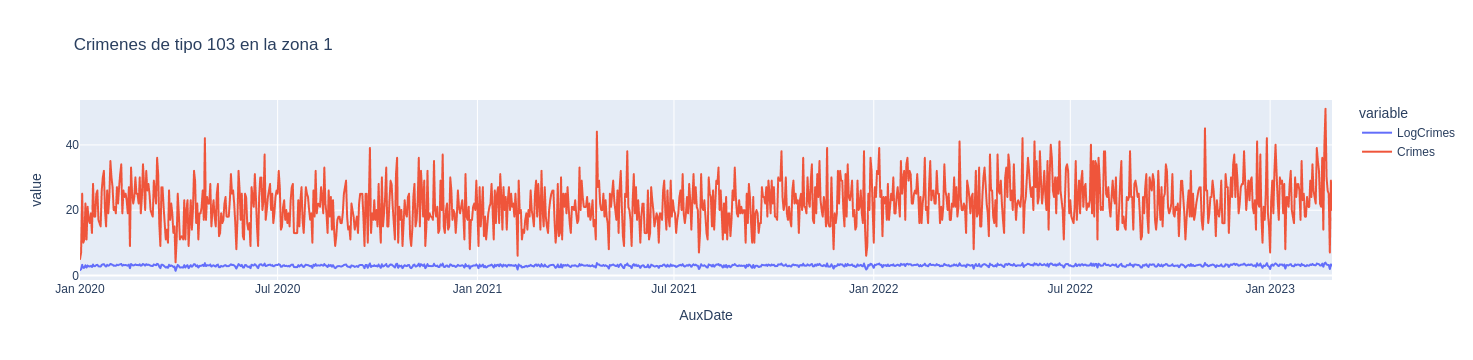

In [10]:
fig = px.line(aux, x="AuxDate", y="value", color="variable",title=f"Crimenes de tipo 103 en la zona 1")
fig.show()

#### Lags

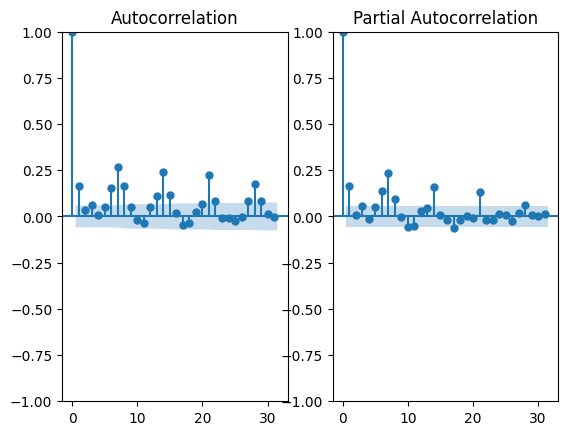

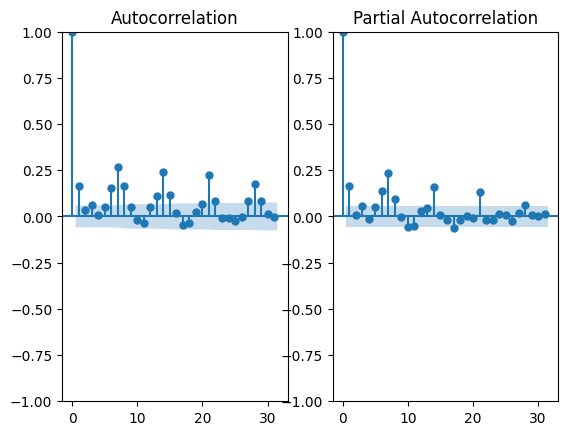

In [11]:
f= plt.figure()
ax1= f.add_subplot(121)
plot_acf(df["LogCrimes"], ax= ax1)
ax2= f.add_subplot(122)
plot_pacf(df["LogCrimes"],ax=ax2)

In [12]:
for i in range(1,8 ):
        df[f"Lag(t-{i})"] = df["LogCrimes"].shift(i)

#### Generate Target

In [13]:
df["y"]= df["LogCrimes"].shift(-1)

In [14]:
df.dropna(inplace=True)

In [15]:
np.isinf(df.iloc[:,1:]).sum()

Crimes       0
LogCrimes    0
Lag(t-1)     0
Lag(t-2)     0
Lag(t-3)     0
Lag(t-4)     0
Lag(t-5)     0
Lag(t-6)     0
Lag(t-7)     0
y            0
dtype: int64

In [16]:
df["y"].iplot()

### Train-test split

In [17]:
train_features = [x for x in df.columns if x != "y"]
train_features.remove("Crimes")
train_features.remove("AuxDate")

In [18]:
X = df[train_features]
y = df[["y"]]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y.interpolate(), test_size=0.3, shuffle=False)

### Scaling

In [20]:
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

In [21]:
X_train = sc_x.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train)

In [22]:
X_test = sc_x.transform(X_test)
y_test = sc_y.transform(y_test)

In [25]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Modeling

### Architecture

In [26]:
model = Sequential()

2023-03-24 07:18:54.908975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-24 07:18:54.918179: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 07:18:54.918318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bluterplay-HP): /proc/driver/nvidia/version does not exist
2023-03-24 07:18:54.950524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.add(LSTM(10, input_shape=X_train.shape[1:], activation="tanh"))

In [28]:
model.add(Dense(100, activation="sigmoid"))

In [29]:
model.add(Dense(1))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                760       
                                                                 
 dense (Dense)               (None, 100)               1100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


### Metrics

In [31]:
kmetrics = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae'),
    metrics.MeanAbsolutePercentageError(name="pema")
]   

### Callbacks

In [32]:
early_stopping = EarlyStopping(monitor='val_mae', patience=20)

In [33]:
checkpoint = ModelCheckpoint('models/crimes/model_{val_mae:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_mae')

### Setup

In [34]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=kmetrics)

## Training

In [35]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/100
12/12 [==============================] - 6s 102ms/step - loss: 0.0388 - rms: 0.1970 - mae: 0.1612 - pema: 635156.9375 - val_loss: 0.0192 - val_rms: 0.1384 - val_mae: 0.1054 - val_pema: 17.5072
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0216 - rms: 0.1469 - mae: 0.1159 - pema: 787479.3125 - val_loss: 0.0320 - val_rms: 0.1790 - val_mae: 0.1513 - val_pema: 20.4994
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0194 - rms: 0.1392 - mae: 0.1092 - pema: 805017.8750 - val_loss: 0.0180 - val_rms: 0.1342 - val_mae: 0.1055 - val_pema: 16.1188
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0188 - rms: 0.1372 - mae: 0.1055 - pema: 843656.5625 - val_loss: 0.0247 - val_rms: 0.1571 - val_mae: 0.1289 - val_pema: 18.0468
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0191 - rms: 0.1382 - mae: 0.1094 - pema: 813394.0625 - val_loss: 0.0197 - val_rms: 0.1404 - val_mae: 0.1122 

In [36]:
results = pd.DataFrame(history.history)

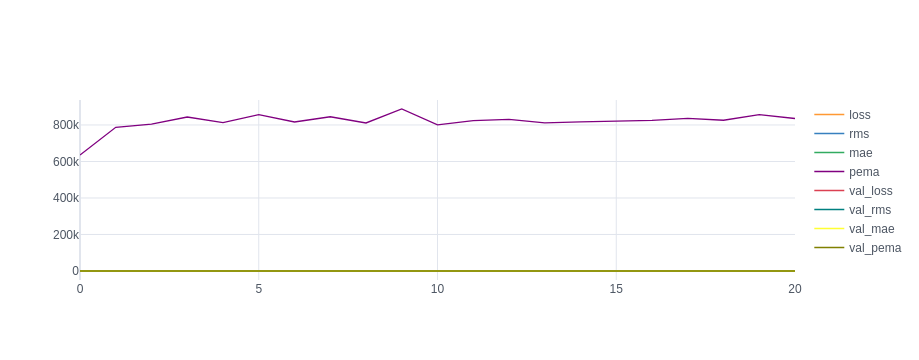

In [37]:
results.iplot()

In [38]:
df["y_hat"] = sc_y.inverse_transform(model.predict(sc_x.transform(df[X.columns]).reshape(df.shape[0], 1, len(train_features))))

36/36 [==============================] - 1s 3ms/step


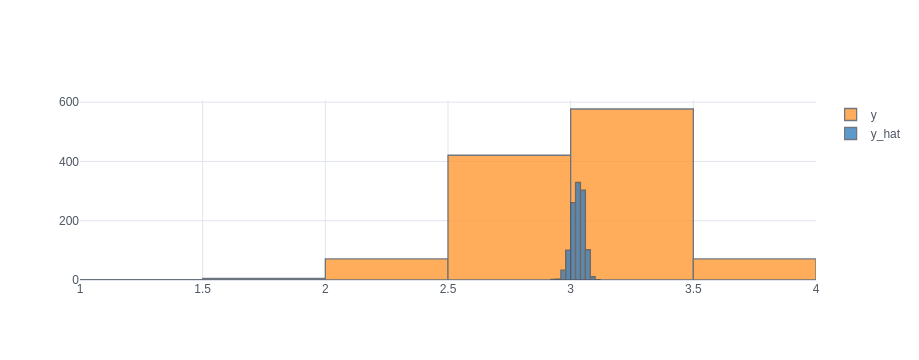

In [39]:
df[["y", "y_hat"]].iplot(kind="hist", bins=10)

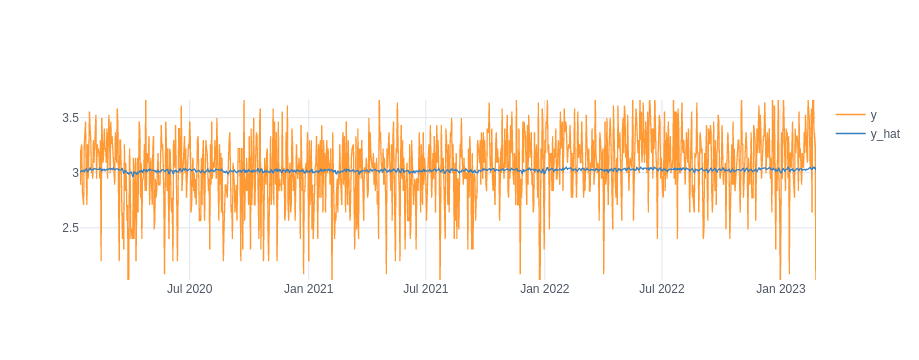

In [144]:
df[["y", "y_hat"]].iplot()

In [ ]:
res